In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import sys
import os 
import h5py
import yaml
import tqdm

sys.path.append('../src/')

from f2_cluster_functions import linearizeFP, PVEofPCA, calcSilhScore,calcSilhScoreHierarch, getTopFCatProp, getWF, getFP, getSgram, calcFFT


yamlPath = "/Users/theresasawi/Documents/11_Manuscripts/Methods_Paper/data/yaml/demo.yaml"

In [2]:


####################################################################################
####################################################################################
###
### Load yaml file settings, creat paths, set parameters
###
####################################################################################
####################################################################################



with open(yamlPath) as stream:
    config = yaml.safe_load(stream)
    
path_config = config["paths"]
key = path_config["key"]
print("Project key:", key)



projectPath = path_config["projectPath"]
SpecUFEx_H5_name = 'SpecUFEx_' + path_config["h5name"] #f'SpecUFEx_{key}.hdf5'
SpecUFEx_H5_path = projectPath + 'data/H5files/' + SpecUFEx_H5_name

pathFig = projectPath + 'reports/figures/'
if not os.path.isdir(pathFig):
    os.mkdir(pathFig)
    

#Clustering parameters
cluster_config = config['clusterParams']
clusterOn = cluster_config['clusterOn']               
PVE = cluster_config['PVE']               
method = cluster_config['method']
minK = cluster_config['minK']
maxK = cluster_config['maxK']        
numEx = cluster_config['numEx']       
standardScaler = cluster_config['standardScaler']

Project key: demo


In [3]:
####################################################################################
####################################################################################
###
### Import fingerprints event ids, load and linearize FPs 
###
####################################################################################
####################################################################################

ev_IDs = []

with h5py.File(SpecUFEx_H5_path,'a') as fileLoad:
    for evID in fileLoad['fingerprints']:
        ev_IDs.append(evID)

        



X = linearizeFP(SpecUFEx_H5_path,ev_IDs) #event IDs needed to get fp from H5



col_names = ['fp' + str(a) for a in range(X.shape[1])]
col_names[-1]

fp_df = pd.DataFrame(X,columns=col_names)
fp_df['ev_ID'] = [str(ev) for ev in ev_IDs]
fp_df['event_ID'] = [str(ev) for ev in ev_IDs]

N = len(fp_df)

print(X.shape)
        

(1815, 225)


In [4]:


####################################################################################
####################################################################################
###
### Perform PCA, create df of PCs up to selected PVE
###
####################################################################################
####################################################################################


PCA_df, numPCA, cum_pve = PVEofPCA(X,cum_pve_thresh=PVE,stand=standardScaler)
XPCA = np.array(PCA_df)


1 0.632282498001
2 0.820829574485
3 0.927129637892
break


In [5]:
####################################################################################
####################################################################################
###
### Clustering: Kmeans or Hierarchical
###
####################################################################################
####################################################################################

range_n_clusters = np.arange(minK,maxK+1)

if method=='kmeans':
    


    Kopt, maxSilScore, avgSils, __, cluster_labels_best, ss_best, __ = calcSilhScore(XPCA,range_n_clusters)

    
    
elif method=='hierarchical':
    

    Kopt, maxSilScore, avgSils, cluster_labels_best, ss_best = calcSilhScoreHierarch(XPCA,range_n_clusters)
    
else:
    
    print('Choose "kmeans" or "hierarchical"')
    
    
# Attach cluster labels to dataframes    
PCA_df['Cluster'] = cluster_labels_best
PCA_df['SS'] = ss_best



kmeans on 2 clusters...
kmeans on 3 clusters...
kmeans on 4 clusters...
kmeans on 5 clusters...
kmeans on 6 clusters...
kmeans on 7 clusters...
kmeans on 8 clusters...
kmeans on 9 clusters...
kmeans on 10 clusters...
Best cluster: 4


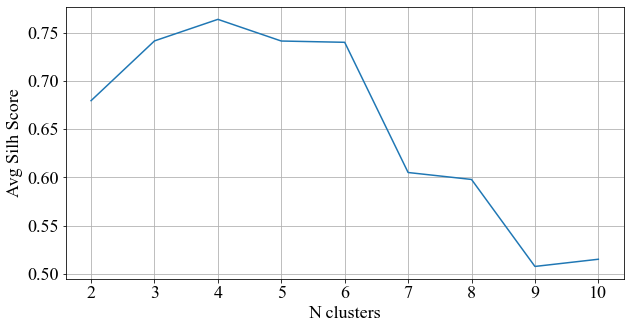

In [13]:
####################################################################################
####################################################################################
###
### Figure 1. Clustering metrics
###
####################################################################################
####################################################################################

plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(10,5))

ax = plt.gca()
ax.plot(range_n_clusters,avgSils)
ax.set_xlabel('N clusters')
ax.set_ylabel('Avg Silh Score')
ax.set_xticks(range_n_clusters);
ax.grid()



plt.savefig(pathFig + key + "SilhScore.png")

# plt.close()


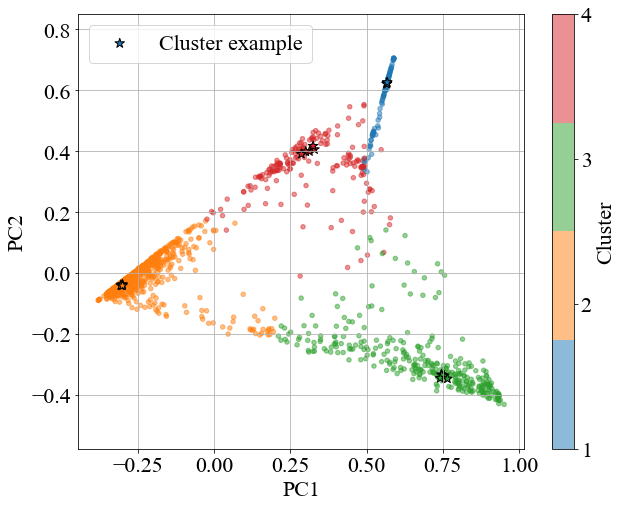

In [14]:


####################################################################################
####################################################################################
###
### Figure 2. PCA colored by cluster assignment
###
####################################################################################
####################################################################################


plt.rcParams.update({'font.size': 22})

fig = plt.figure(figsize=(10,8))
ax = plt.gca()

## Make cluster colormap
cluster_colors = [plt.cm.tab20(i) for i in range(0,Kopt)]
if Kopt <= 10:
    cluster_colors = [plt.cm.tab10(i) for i in range(0,Kopt)]
cmap = ListedColormap(cluster_colors)




topF_df_PCA_list = [] 

for cl in range(1,Kopt+1):
    
    PCA_df_k = PCA_df[PCA_df.Cluster==cl].copy()
    PCA_df_k.sort_values(by=['SS'],ascending=[False],inplace=True)

    topF_df_PCA_list.append(PCA_df_k.iloc[0:numEx])
    
    
topF_df_PCA_list_df = pd.concat(topF_df_PCA_list)    


im = ax.scatter(PCA_df.PC1,PCA_df.PC2,c=PCA_df.Cluster,alpha=.5,cmap=cmap,s=20)
ax.scatter(topF_df_PCA_list_df.PC1,topF_df_PCA_list_df.PC2,marker='*',
           c=topF_df_PCA_list_df.Cluster,s=100,cmap=cmap,edgecolor='k',
           label='Cluster example')

plt.colorbar(im, ticks=range(1,Kopt+1),label='Cluster',ax=ax)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.axis('equal')
ax.grid()
ax.legend();


plt.savefig(pathFig + key + "PCACluster.png")
# plt.close()

In [8]:
####################################################################################
####################################################################################
###
### Figure 3. Plot spectrogram examples
###
####################################################################################
####################################################################################
plt.rcParams.update({'font.size': 16})



fig, axes = plt.subplots(nrows=Kopt, ncols=numEx, figsize=(numEx*2,Kopt*1.5))

## get sgram freqs and time vectors
with h5py.File(SpecUFEx_H5_path,'a') as fileLoad:
    
    frequencies = fileLoad['fSTFT'].get('fSTFT')[()]
    times =       fileLoad['tSTFT'].get('tSTFT')[()]

    
    
for cl in range(1,Kopt+1):
    
    PCA_df_k = PCA_df[PCA_df.Cluster==cl].copy()
    PCA_df_k.sort_values(by=['SS'],ascending=[False],inplace=True)

    for i in tqdm.tqdm(range(numEx)):
        
        ax = axes[cl-1][i]
        
        indd = PCA_df_k.index[i]
        
        tSTFT, fSTFT, sgram = getSgram(ev_IDs[indd], SpecUFEx_H5_path)
        im = ax.pcolormesh(tSTFT,
                            fSTFT,
                            sgram,
                            cmap=plt.cm.viridis,
                            shading='auto')

           
            
        if i==numEx//2:
            ax.set_xlabel('Time (s)')
            
        if i ==0:
            ax.set_ylabel('Cl' + str(cl) + '\n f (Hz)') 
            
        if cl!=Kopt:
            ax.set_xlabel('')
            ax.set_xticklabels([])           
            ax.set_xticks([])        
        
        if i!=0:
            ax.set_yticks([])
            ax.set_yticklabels([])


            
        if cl==1:    
            ax.set_title('Example ' + str(i+1),pad=5,fontsize=12)     

    




plt.savefig(pathFig + key + "ClusterExamples.png")
plt.close()


100%|██████████| 5/5 [00:00<00:00, 43.62it/s]


In [10]:
####################################################################################
####################################################################################
###
### Attach datetimes, get hod etc
###
####################################################################################
####################################################################################

binSize = 'M'

PCA_df['event_ID'] = ev_IDs
datetime_format = "%Y.%j.%H%M%S"
datetime = [pd.to_datetime(ds[14:], format=datetime_format) for ds in PCA_df['event_ID']]
# datetime = [pd.to_datetime(ds[14:-9], format=datetime_format) for ds in PCA_df['event_ID']]

PCA_df['datetime'] = datetime
PCA_df['datetime_index'] = datetime
PCA_df_dt = PCA_df.set_index('datetime_index')

PCA_df_dt['hod'] = [dt.hour for dt in PCA_df_dt['datetime']] 


/Users/theresasawi/opt/anaconda3/envs/seismo2/lib/python3.7/site-packages/ipykernel_launcher.py:142: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error in 3.6


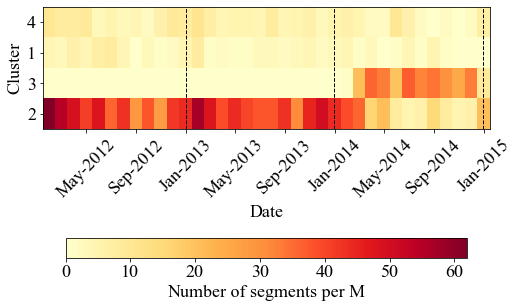

In [12]:
from scipy.signal import find_peaks

from matplotlib.dates import DateFormatter

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams.update({'font.size': 18})


####################################################################################
####################################################################################
###
### Make Heatmap
###
####################################################################################
####################################################################################


PCA_list = []
for cl in range(1,Kopt+1):
    df_k = PCA_df_dt[PCA_df_dt.Cluster==cl]
    PCA_list.append(df_k)
    
    
# Create a list of cluster counts for each cluster in PCA_df_list resampled at binSize interval
cluster_counts = [PCA_list[i].resample(binSize).count().Cluster for i in range(Kopt)]



# Create a DataFrame with cluster counts for each cluster
heat_df = pd.DataFrame({f'Cl{i+1}': counts for i, counts in enumerate(cluster_counts)})

heat_df = heat_df.fillna(0)


max_Cl_count = np.max(heat_df,0)
heat_df_norm = heat_df / max_Cl_count 









# ####################################################################################
# ####################################################################################
# ###
# ### Reorder cluster
# ###
# ####################################################################################
# ####################################################################################

peaks_list = []
for cl in range(Kopt):
    heat_df_cl = heat_df.iloc[:,cl]

    peaks, props = find_peaks(heat_df_cl,height=25)
    
    try:
        peaks_list.append(peaks[0])
    except:
        peaks_list.append(999)
    
peaks_df = pd.DataFrame({'peaks':peaks_list,
                         'Cluster':range(1,Kopt+1)})

peaks_df.sort_values(by='peaks',inplace=True,ascending=True)

cluster_reorder = list(peaks_df.Cluster)
# ####################################################################################
# ####################################################################################
# ###
# ### Make Heatmap, reordered
# ###
# ####################################################################################
# ####################################################################################
    
    
# Create a list of cluster counts for each cluster in PCA_df_list resampled at binSize interval
cluster_counts = [PCA_list[i-1].resample(binSize).count().Cluster for i in cluster_reorder]



# Create a DataFrame with cluster counts for each cluster
heat_df_reorder = pd.DataFrame({f'Cl{i}': counts for i, counts in zip(cluster_reorder,cluster_counts)})

heat_df_reorder = heat_df_reorder.fillna(0)


max_Cl_count = np.max(heat_df_reorder,0)
heat_df_norm_reorder = heat_df_reorder / max_Cl_count 


####################################################################################
####################################################################################
###
### Plot Heatmap
###
####################################################################################
####################################################################################
# plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(8,5))
ax = plt.gca()



im = ax.pcolormesh(heat_df_reorder.index,range(1,Kopt+1),heat_df_reorder.T,cmap='YlOrRd',shading='auto')#,vmax=20)
# im = ax.pcolormesh(heat_df.index,range(1,Kopt+1),heat_df.T,cmap='afmhot_r',shading='auto')#,vmax=20)

ax.set_yticks([r+1  for r in range(Kopt)])
ax.set_yticklabels(cluster_reorder)

plt.colorbar(im, 
             label=f'Number of segments per {binSize}', 
             orientation='horizontal', 
             pad=0.4,
            shrink=.9,
             ax=ax)#,extend='max')

###----------------------------------------------
### DATELINES
###----------------------------------------------
start_date = '2012-01-01'
end_date = '2015-01-01'
date_range = pd.date_range(start=start_date, end=end_date, freq='Y')
df = pd.DataFrame({'date': date_range})

[ax.axvline(df.iloc[j],lw=1,color='k',ls='--') for j in range(len(df))]

ax.set_ylabel('Cluster')
ax.set_xlabel('Date')

ax.tick_params(axis='x',rotation=45)


ax.xaxis.set_major_formatter(DateFormatter('%b-%Y'))



plt.savefig(pathFig + "4_" + key + "_heatmap.png", bbox_to_inches='tight',dpi=300)